In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import time
import os
import copy
import pandas as pd
import cv2
import json
from torchinfo import summary
from PIL import Image
import sys
import tqdm
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from collections import defaultdict
import random

In [7]:
#Create balanced dataloader

class_train_size = 500

train_ids_full = defaultdict(list)
val_ids_balanced = []
test_ids_balanced = []

period_to_label = {}
label = 0

for period in periodWiseDict.keys():
    pvalues = periodWiseDict[period]
    if len(pvalues) >= class_train_size*0.2: #so that we can have 5%test, 5%val and 10%train atleast
        random.shuffle(pvalues)
#         for pval in pvalues[:int(class_train_size*0.05)]:
#             val_ids_balanced[pval] = label
#             val_ids_balanced.append((pval, label))
#         for pval in pvalues[int(class_train_size*0.05):int(class_train_size*0.10)]:
#             test_ids_balanced.append((pval, label))
#             test_ids_balanced[pval] = label
#         for pval in pvalues[int(class_train_size*0.10):]:
#             train_ids_full[label].append((pval, label))
        val_ids_balanced = val_ids_balanced + pvalues[:int(class_train_size*0.05)]
        test_ids_balanced = test_ids_balanced + pvalues[int(class_train_size*0.05):int(class_train_size*0.10)]
        train_ids_full[label] = pvalues[int(class_train_size*0.10):]                                               
        period_to_label[period] = label
        label+=1


In [8]:
period_to_label

{'Uruk III (ca. 3200-3000 BC)': 0,
 'Uruk IV (ca. 3350-3200 BC)': 1,
 'Early Old Babylonian (ca. 2000-1900 BC)': 2,
 'ED I-II (ca. 2900-2700 BC)': 3,
 'Uruk V (ca. 3500-3350 BC)': 4,
 'ED IIIa (ca. 2600-2500 BC)': 5,
 'Proto-Elamite (ca. 3100-2900 BC)': 6,
 'Old Babylonian (ca. 1900-1600 BC)': 7,
 'ED IIIb (ca. 2500-2340 BC)': 8,
 'Old Akkadian (ca. 2340-2200 BC)': 9,
 'Neo-Assyrian (ca. 911-612 BC)': 10,
 'Ur III (ca. 2100-2000 BC)': 11,
 'Lagash II (ca. 2200-2100 BC)': 12,
 'Neo-Babylonian (ca. 626-539 BC)': 13,
 'Old Assyrian (ca. 1950-1850 BC)': 14,
 'Middle Babylonian (ca. 1400-1100 BC)': 15,
 'Ebla (ca. 2350-2250 BC)': 16,
 'Middle Assyrian (ca. 1400-1000 BC)': 17}

In [9]:
class CuneiformDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        """
        Arguments:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.catalogue = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.catalogue)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        pid = self.catalogue.iloc[idx]["id"]
        image_name = "P"+ str(pid).zfill(6)+".jpg"
        image_path = os.path.join(self.root_dir,image_name)
        
        
        image = Image.open(image_path)
        period = self.catalogue.iloc[idx]["period.period"]
        
        label = period_to_label[period]
        
        if self.transform:
            image = self.transform(image)

        sample = {'image': image,
                  'label': label,
                  'period': period,
                 }
        return sample
    
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")



In [11]:

resnet101_weights = torchvision.models.ResNet101_Weights.DEFAULT
resnet101_model = torchvision.models.resnet101(weights=resnet101_weights).to(device)
# printModelSummary(model)
resnet101_model.fc = nn.Sequential(
    nn.BatchNorm1d(2048),
    nn.Dropout(p=0.25),
    nn.Linear(in_features=2048, out_features=1024),
    nn.ReLU(),
    nn.BatchNorm1d(1024, eps=1e-05, momentum=0.1),
    nn.Dropout(p=0.5),
    nn.Linear(in_features=1024, out_features=18),
)
printModelSummary(resnet101_model)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [32, 3, 224, 224]    [32, 18]             --                   True
├─Conv2d (conv1)                         [32, 3, 224, 224]    [32, 64, 112, 112]   9,408                True
├─BatchNorm2d (bn1)                      [32, 64, 112, 112]   [32, 64, 112, 112]   128                  True
├─ReLU (relu)                            [32, 64, 112, 112]   [32, 64, 112, 112]   --                   --
├─MaxPool2d (maxpool)                    [32, 64, 112, 112]   [32, 64, 56, 56]     --                   --
├─Sequential (layer1)                    [32, 64, 56, 56]     [32, 256, 56, 56]    --                   True
│    └─Bottleneck (0)                    [32, 64, 56, 56]     [32, 256, 56, 56]    --                   True
│    │    └─Conv2d (conv1)               [32, 64, 56, 56]     [32, 64, 56, 56]     4,096                True
│    │    └─BatchN

In [32]:
#balanced training, create a new dataset at every epoch:

batch_size = 16
num_epochs = 7
lr = 0.0001
weight_decay = 1e-1

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(resnet101_model.parameters(), lr=lr, weight_decay=weight_decay)

In [14]:
#create val and test dataloader (will remain same throughout epochs)

val_df = df.loc[df['id'].isin(val_ids_balanced)]
print(val_df.shape)
val_df.to_csv("temp/val_df.csv")

test_df = df.loc[df['id'].isin(test_ids_balanced)]
print(test_df.shape)
test_df.to_csv("temp/test_df.csv")


val_dataset = CuneiformDataset(csv_file='temp/val_df.csv', root_dir='../full_data/segmented_images/', transform=data_transforms['val'])
test_dataset = CuneiformDataset(csv_file='temp/test_df.csv', root_dir='../full_data/segmented_images/', transform=data_transforms['val'])

val_dataset_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_dataset_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

(450, 99)
(450, 99)


In [26]:
def upsample(idlist, size):
    out = []
    while len(out)<size:
        out = out + idlist
    random.shuffle(out)
    return out[:size]

In [47]:
def train_model_balanced(model):

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        print('-' * 100)
          
    #create train dataloader
        train_ids_balanced = []
        for lbl,idlist in train_ids_full.items():
            if len(idlist) > class_train_size:
#                 train_ids_balanced.append(idlist[class_train_size*epoch:class_train_size*(epoch+1)])
                train_ids_balanced = train_ids_balanced + random.sample(idlist, class_train_size)  #TODO: This should not be a random sample
            else:
                train_ids_balanced = train_ids_balanced + upsample(idlist, class_train_size)
        print(len(train_ids_balanced))
        
        
        train_df = df.loc[df['id'].isin(train_ids_balanced)] # TODO: this is nullifying the impact of upsampling
        print(train_df.shape)
        train_df.to_csv("temp/train_df.csv")

        train_dataset = CuneiformDataset(csv_file='temp/train_df.csv', root_dir='../full_data/segmented_images/', transform=data_transforms['train'])
        train_dataset_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        
        train_dataset_size = len(train_dataset_loader)
        val_dataset_size = len(val_dataset_loader) 
        
        model.train()
        
        running_loss = 0.0
        train_true_labels = []
        train_pred_labels = []
        
        for idx, sample in tqdm.tqdm(enumerate(train_dataset_loader)):
            inputs = sample["image"]
            labels = sample["label"]
            train_true_labels = train_true_labels + labels.tolist()
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            with torch.set_grad_enabled(True):
                outputs = model(inputs)
                logits = outputs.detach().cpu().numpy()
                train_pred_labels = train_pred_labels+ np.argmax(logits, axis =1).flatten().tolist()
                
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

            running_loss += loss.item() * inputs.size(0)
        epoch_train_loss = running_loss / train_dataset_size
        epoch_train_accuracy = accuracy_score(train_true_labels, train_pred_labels)
        print('Train Loss: {:.4f}'.format(epoch_train_loss), 'Train Accuracy: ',epoch_train_accuracy )
        
        
        model.eval()
        
        
        running_loss = 0.0
        val_true_labels = []
        val_pred_labels = []
        for idx, sample in tqdm.tqdm(enumerate(val_dataset_loader)):
            inputs = sample["image"]
            labels = sample["label"]
            val_true_labels = val_true_labels + labels.tolist()
            inputs = inputs.to(device)
            labels = labels.to(device)
    
            optimizer.zero_grad()

            with torch.set_grad_enabled(True):
                outputs = model(inputs)
                logits = outputs.detach().cpu().numpy()
                val_pred_labels = val_pred_labels+ np.argmax(logits, axis =1).flatten().tolist()
                loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
        epoch_val_loss = running_loss / val_dataset_size
        epoch_val_accuracy = accuracy_score(val_true_labels, val_pred_labels)
        print('Val Loss: {:.4f}'.format(epoch_val_loss), 'Val Accuracy: ',epoch_val_accuracy )
        
    return model

In [48]:
train_model_balanced(resnet101_model)

Epoch 1/7
----------------------------------------------------------------------------------------------------
9000
(7143, 99)


447it [01:43,  4.32it/s]


Train Loss: 22.0468 Train Accuracy:  0.5700685986280274


29it [00:06,  4.78it/s]


Val Loss: 19.2665 Val Accuracy:  0.6111111111111112
Epoch 2/7
----------------------------------------------------------------------------------------------------
9000
(7142, 99)


271it [00:59,  4.59it/s]


FileNotFoundError: [Errno 2] No such file or directory: '../full_data/segmented_images/P290806.jpg'

In [38]:
# train_dataset = CuneiformDataset(csv_file='data/train_df.csv',
#                                     root_dir='data/train/', transform=data_transforms['train'])
# val_dataset = CuneiformDataset(csv_file='data/val_df.csv',
#                                     root_dir='data/val/', transform=data_transforms['val'])

In [37]:
train_dataset[0]['image'].size()

NameError: name 'train_dataset' is not defined

In [27]:
# batch_size = 16
# epochs = 7
# lr = 0.0001
# weight_decay = 1e-1

# train_dataset_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# val_dataset_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

# criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.AdamW(resnet101_model.parameters(), lr=lr, weight_decay=weight_decay)
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=15, eta_min=1e-4)

In [28]:
def train_model(model, train_data_loader, val_data_loader, optimizer, num_epochs, criterion):
    train_dataset_size = len(train_data_loader)
    val_dataset_size = len(val_data_loader)
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        print('-' * 100)

        model.train()
        
        running_loss = 0.0
        train_true_labels = []
        train_pred_labels = []
        
        for idx, sample in tqdm.tqdm(enumerate(train_data_loader)):
            inputs = sample["image"]
            labels = sample["label"]
            train_true_labels = train_true_labels + labels.tolist()
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            with torch.set_grad_enabled(True):
                outputs = model(inputs)
                logits = outputs.detach().cpu().numpy()
                train_pred_labels = train_pred_labels+ np.argmax(logits, axis =1).flatten().tolist()
                
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

            running_loss += loss.item() * inputs.size(0)
        epoch_train_loss = running_loss / train_dataset_size
        epoch_train_accuracy = accuracy_score(train_true_labels, train_pred_labels)
        print('Train Loss: {:.4f}'.format(epoch_train_loss), 'Train Accuracy: ',epoch_train_accuracy )
        
        
        model.eval()
        
        
        running_loss = 0.0
        val_true_labels = []
        val_pred_labels = []
        for idx, sample in tqdm.tqdm(enumerate(val_data_loader)):
            inputs = sample["image"]
            labels = sample["label"]
            val_true_labels = val_true_labels + labels.tolist()
            inputs = inputs.to(device)
            labels = labels.to(device)
    
            optimizer.zero_grad()

            with torch.set_grad_enabled(True):
                outputs = model(inputs)
                logits = outputs.detach().cpu().numpy()
                val_pred_labels = val_pred_labels+ np.argmax(logits, axis =1).flatten().tolist()
                loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
        epoch_val_loss = running_loss / val_dataset_size
        epoch_val_accuracy = accuracy_score(val_true_labels, val_pred_labels)
        print('Val Loss: {:.4f}'.format(epoch_val_loss), 'Val Accuracy: ',epoch_val_accuracy )
        
    return model

In [29]:
model = train_model( resnet101_model, train_dataset_loader, val_dataset_loader, optimizer, epochs, criterion)

Epoch 1/7
----------------------------------------------------------------------------------------------------


783it [02:07,  6.14it/s]


Train Loss: 30.0759 Train Accuracy:  0.43913147601181446


81it [00:09,  8.75it/s]


Val Loss: 23.5910 Val Accuracy:  0.524551831644583
Epoch 2/7
----------------------------------------------------------------------------------------------------


783it [02:29,  5.24it/s]


Train Loss: 19.2423 Train Accuracy:  0.6282429951305181


81it [00:09,  8.62it/s]


Val Loss: 21.8495 Val Accuracy:  0.5759937646141855
Epoch 3/7
----------------------------------------------------------------------------------------------------


783it [02:07,  6.13it/s]


Train Loss: 14.1891 Train Accuracy:  0.7205236688752295


81it [00:09,  8.64it/s]


Val Loss: 20.7223 Val Accuracy:  0.6095089633671084
Epoch 4/7
----------------------------------------------------------------------------------------------------


783it [02:07,  6.16it/s]


Train Loss: 10.0570 Train Accuracy:  0.8003512413187515


81it [00:09,  8.56it/s]


Val Loss: 20.7834 Val Accuracy:  0.6243180046765393
Epoch 5/7
----------------------------------------------------------------------------------------------------


783it [02:29,  5.24it/s]


Train Loss: 7.4358 Train Accuracy:  0.8515207152550491


81it [00:11,  7.22it/s]


Val Loss: 20.1693 Val Accuracy:  0.6383476227591582
Epoch 6/7
----------------------------------------------------------------------------------------------------


783it [02:06,  6.19it/s]


Train Loss: 5.7349 Train Accuracy:  0.8880019158617386


81it [00:09,  8.67it/s]


Val Loss: 20.8270 Val Accuracy:  0.6461418550272798
Epoch 7/7
----------------------------------------------------------------------------------------------------


783it [02:06,  6.17it/s]


Train Loss: 4.5450 Train Accuracy:  0.9071605332481839


81it [00:09,  8.66it/s]

Val Loss: 21.4111 Val Accuracy:  0.6282151208106002


In [31]:
#TODO: Add early stopping and checkpointing
# Check f1 score 
running_loss = 0.0
val_dataset_size = len(val_dataset_loader)
val_true_labels = []
val_pred_labels = []
for idx, sample in tqdm.tqdm(enumerate(val_dataset_loader)):
    inputs = sample["image"]
    labels = sample["label"]
    val_true_labels = val_true_labels + labels.tolist()
    inputs = inputs.to(device)
    labels = labels.to(device)

    optimizer.zero_grad()

    with torch.set_grad_enabled(True):
        outputs = model(inputs)
        logits = outputs.detach().cpu().numpy()
        val_pred_labels = val_pred_labels+ np.argmax(logits, axis =1).flatten().tolist()
        loss = criterion(outputs, labels)

    running_loss += loss.item() * inputs.size(0)
epoch_val_loss = running_loss / val_dataset_size
epoch_val_accuracy = accuracy_score(val_true_labels, val_pred_labels)
print('Val Loss: {:.4f}'.format(epoch_val_loss), 'Val Accuracy: ',epoch_val_accuracy )

81it [00:09,  8.56it/s]

Val Loss: 21.4111 Val Accuracy:  0.6282151208106002


In [33]:
from sklearn.metrics import confusion_matrix
cf_matrix =confusion_matrix(val_true_labels, val_pred_labels)

<Axes: >

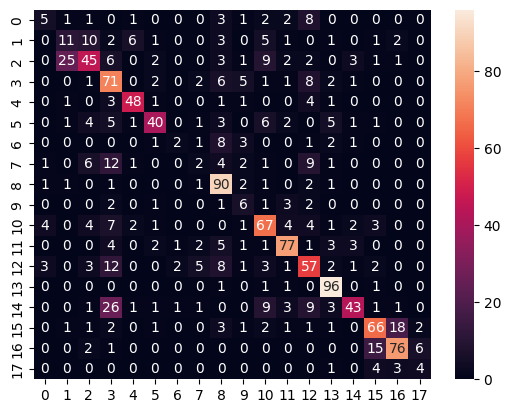

In [36]:
import seaborn as sns
sns.heatmap(cf_matrix, annot=True)

In [39]:
period_to_label

{'ED I-II (ca. 2900-2700 BC)': 0,
 'ED IIIa (ca. 2600-2500 BC)': 1,
 'ED IIIb (ca. 2500-2340 BC)': 2,
 'Early Old Babylonian (ca. 2000-1900 BC)': 3,
 'Ebla (ca. 2350-2250 BC)': 4,
 'Lagash II (ca. 2200-2100 BC)': 5,
 'Middle Assyrian (ca. 1400-1000 BC)': 6,
 'Middle Babylonian (ca. 1400-1100 BC)': 7,
 'Neo-Assyrian (ca. 911-612 BC)': 8,
 'Neo-Babylonian (ca. 626-539 BC)': 9,
 'Old Akkadian (ca. 2340-2200 BC)': 10,
 'Old Assyrian (ca. 1950-1850 BC)': 11,
 'Old Babylonian (ca. 1900-1600 BC)': 12,
 'Proto-Elamite (ca. 3100-2900 BC)': 13,
 'Ur III (ca. 2100-2000 BC)': 14,
 'Uruk III (ca. 3200-3000 BC)': 15,
 'Uruk IV (ca. 3350-3200 BC)': 16,
 'Uruk V (ca. 3500-3350 BC)': 17}

In [40]:
# !nvidia-smi

In [41]:
# !kill -9 25366

In [23]:
torch.cuda.empty_cache()

In [24]:
import random

mylist = ["apple", "banana", "cherry"]
random.shuffle(mylist)

print(mylist)

['banana', 'apple', 'cherry']


In [18]:

# period_to_label = {'ED I-II (ca. 2900-2700 BC)': 0, 'ED IIIa (ca. 2600-2500 BC)': 1, 'ED IIIb (ca. 2500-2340 BC)': 2, 
#  'Early Old Babylonian (ca. 2000-1900 BC)': 3, 'Ebla (ca. 2350-2250 BC)': 4, 'Lagash II (ca. 2200-2100 BC)': 5, 
#  'Middle Assyrian (ca. 1400-1000 BC)': 6, 'Middle Babylonian (ca. 1400-1100 BC)': 7, 
#  'Neo-Assyrian (ca. 911-612 BC)': 8, 'Neo-Babylonian (ca. 626-539 BC)': 9, 'Old Akkadian (ca. 2340-2200 BC)': 10, 
#  'Old Assyrian (ca. 1950-1850 BC)': 11, 'Old Babylonian (ca. 1900-1600 BC)': 12, 'Proto-Elamite (ca. 3100-2900 BC)': 13, 
#  'Ur III (ca. 2100-2000 BC)': 14, 'Uruk III (ca. 3200-3000 BC)': 15, 'Uruk IV (ca. 3350-3200 BC)': 16, 
#  'Uruk V (ca. 3500-3350 BC)': 17}


# with open ("train_ids.json", 'r') as f:
#     train_ids = json.load(f)
# with open ("val_ids.json", 'r') as f:
#     val_ids = json.load(f)

# Run to create train_df.csv and val_df.csv
# df = pd.read_csv('../full_data/expanded_catalogue.csv')  
# print(df.shape)
# train_df = df.loc[df['id'].isin(train_ids)]
# print(train_df.shape)
# val_df = df.loc[df['id'].isin(val_ids)]
# print(val_df.shape)
# train_df.to_csv("data/train_df.csv")
# val_df.to_csv("data/val_df.csv")